In [15]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [17]:
# format data
# take only the the oil price
# predict the final 30 days
# save the test and train data

In [18]:
df.set_index('date', inplace=True)
print(df.shape)
df.head()

(7316300, 21)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [19]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['global_mean', 'state_mean', 'eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7316300, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [20]:
rot = df['rotterdam'][:575]
brent = df['brent'][:575]
wti = df['wti'][:575]

Predict Rotterdam.

In [21]:
# define rot_X as lagged one day and rot_y as rot
rot_y = rot.copy()
rot_x = rot.copy()
# pop the first observation on rot_y and the last on rot_x
rot_y.drop(['2014-05-16'], inplace=True)
rot_x.drop(['2015-12-11'], inplace=True)
# take last 30 days as test
train_rot_x = rot_x[:-31]
train_rot_y = rot_y[:-31]
test_rot_x = rot_x[-31:]
test_rot_y = rot_y[-31:]
# grab the values
v_train_rot_x = train_rot_x.values
v_train_rot_y = train_rot_y.values
v_test_rot_x = test_rot_x.values
v_test_rot_y = test_rot_y.values
# fit model for rot
rot_model = LinearRegression()
rot_model.fit(v_train_rot_x.reshape(543,1), v_train_rot_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

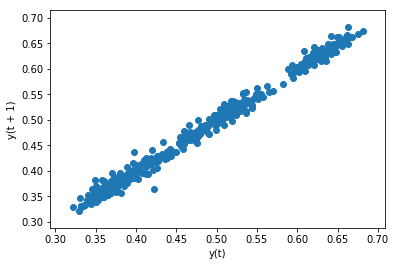

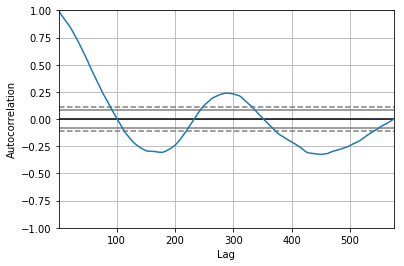

In [33]:
# check for autocorrelation
from matplotlib import pyplot
from pandas.plotting import lag_plot
lag_plot(rot)
pyplot.show()

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(rot)
pyplot.show()

In [10]:
rot_yhat = rot_model.predict(v_test_rot_x.reshape(31,1))

In [11]:
rot_rmse = sqrt(mean_squared_error(test_rot_y, rot_yhat))
rot_rmse

0.0126370523086607

Now, for Brent.

In [136]:
# define brent_X as lagged one day and brent_y as brent
brent_y = brent.copy()
brent_x = brent.copy()
# pop the first observation on brent_y and the last on brent_x
brent_y.drop(['2014-05-16'], inplace=True)
brent_x.drop(['2015-12-11'], inplace=True)
# take last 30 days as test
train_brent_x = brent_x[:-31]
train_brent_y = brent_y[:-31]
test_brent_x = brent_x[-31:]
test_brent_y = brent_y[-31:]
# grab the values
v_train_brent_x = train_brent_x.values
v_train_brent_y = train_brent_y.values
v_test_brent_x = test_brent_x.values
v_test_brent_y = test_brent_y.values
# fit model for rot
brent_model = LinearRegression()
brent_model.fit(v_train_brent_x.reshape(543,1), v_train_brent_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [137]:
brent_yhat = brent_model.predict(v_test_brent_x.reshape(31,1))

In [138]:
brent_rmse = sqrt(mean_squared_error(test_brent_y, brent_yhat))
brent_rmse

0.8439200281866971

Now for WTI

In [139]:
# define wti_X as lagged one day and wti_y as brent
wti_y = wti.copy()
wti_x = wti.copy()
# pop the first observation on brent_y and the last on brent_x
wti_y.drop(['2014-05-16'], inplace=True)
wti_x.drop(['2015-12-11'], inplace=True)
# take last 30 days as test
train_wti_x = wti_x[:-31]
train_wti_y = wti_y[:-31]
test_wti_x = wti_x[-31:]
test_wti_y = wti_y[-31:]
# grab the values
v_train_wti_x = train_wti_x.values
v_train_wti_y = train_wti_y.values
v_test_wti_x = test_wti_x.values
v_test_wti_y = test_wti_y.values
# fit model for wti
wti_model = LinearRegression()
wti_model.fit(v_train_wti_x.reshape(543,1), v_train_wti_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [140]:
wti_yhat = wti_model.predict(v_test_wti_x.reshape(31,1))

In [141]:
wti_rmse = sqrt(mean_squared_error(test_wti_y, wti_yhat))
wti_rmse

0.5823761770435268

Now prepare the data to be used for the linear model and save.

In [142]:
linear_oil_yhat = {'rot_yhat': rot_yhat, 'brent_yhat': brent_yhat, 'wti_yhat': wti_yhat}

In [143]:
linear_oil_yhat_df = pd.DataFrame(data=linear_oil_yhat)

In [144]:
linear_oil_yhat_df.to_csv('./../data/linear_oil_yhat.csv')

In [12]:
rot_yhat

array([0.41012271, 0.42220341, 0.36476138, 0.353382  , 0.34913381,
       0.34488559, 0.3406374 , 0.35393298, 0.35415051, 0.35995003,
       0.36125396, 0.36022143, 0.35918894, 0.35815642, 0.38247602,
       0.37839511, 0.38240467, 0.38602942, 0.38430202, 0.38257462,
       0.38084722, 0.37692958, 0.3657243 , 0.35364642, 0.34413485,
       0.34070685, 0.33727885, 0.33385085, 0.33201942, 0.33209983,
       0.33221692])

In [14]:
test_rot_y

date
2015-11-11    0.422269
2015-11-12    0.364591
2015-11-13    0.353165
2015-11-14    0.348899
2015-11-15    0.344634
2015-11-16    0.340368
2015-11-17    0.353718
2015-11-18    0.353937
2015-11-19    0.359760
2015-11-20    0.361069
2015-11-21    0.360033
2015-11-22    0.358996
2015-11-23    0.357959
2015-11-24    0.382379
2015-11-25    0.378281
2015-11-26    0.382307
2015-11-27    0.385947
2015-11-28    0.384212
2015-11-29    0.382478
2015-11-30    0.380743
2015-12-01    0.376809
2015-12-02    0.365558
2015-12-03    0.353431
2015-12-04    0.343880
2015-12-05    0.340438
2015-12-06    0.336996
2015-12-07    0.333554
2015-12-08    0.331715
2015-12-09    0.331795
2015-12-10    0.331913
2015-12-11    0.332031
Name: rotterdam, dtype: float64